[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4545
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

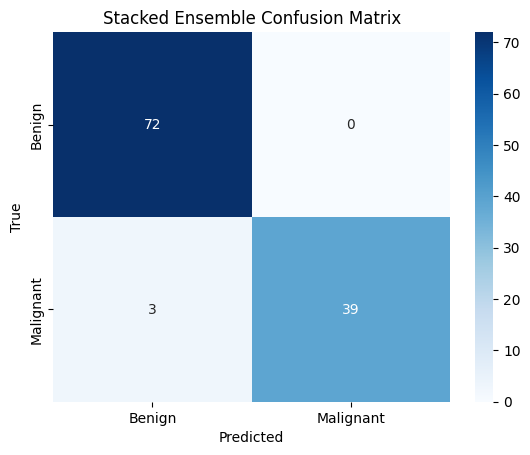

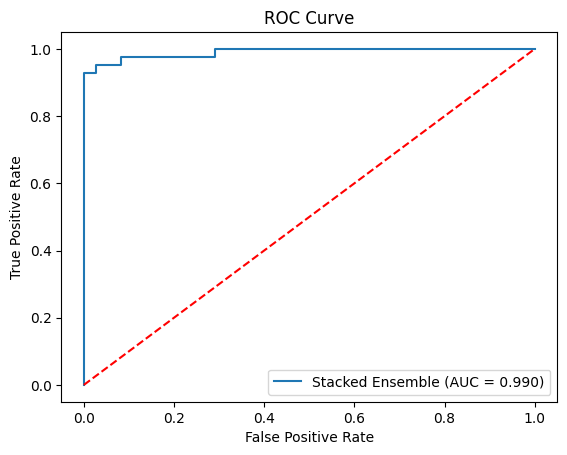

Submission file saved as breast_cancer_submission.csv


In [33]:
# Install libraries (skip if preinstalled)
!pip install xgboost lightgbm shap matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Load dataset
data = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
data = data.drop(columns=['id', 'Unnamed: 32'], errors='ignore')
data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

# Features & target
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base models
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
lgb_model = lgb.LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)

# Stacking ensemble
estimators = [('rf', rf_model), ('lgb', lgb_model), ('xgb', xgb_model)]
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100),
    cv=5,
    n_jobs=1
)
stack_model.fit(X_train_scaled, y_train)

# Predict test set
preds = stack_model.predict(X_test_scaled)
y_probs = stack_model.predict_proba(X_test_scaled)[:,1]

# Evaluation
acc = accuracy_score(y_test, preds)
auc_score = roc_auc_score(y_test, y_probs)
print(f"Stacked Ensemble Accuracy: {acc:.4f}, AUC: {auc_score:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'])
plt.title('Stacked Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Stacked Ensemble (AUC = %0.3f)' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Save submission CSV
submission = pd.DataFrame({
    'id': X_test.index,
    'diagnosis_prediction': preds
})
submission.to_csv('breast_cancer_submission.csv', index=False)
print("Submission file saved as breast_cancer_submission.csv")


In [27]:
print(data.columns)


Index(['id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio'], dtype='object')
